In [4]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [5]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:09<00:00, 11.71it/s]


In [6]:
df.columns = df.columns.str.replace("hourly_", "")

In [7]:
train = df[df['_type']=='train']
test = df[df['_type']=='test']

### Month Day Hour Weekday 별로 close와 volume을 비교해보자

In [8]:
train = train.copy()
train['ID_dt'] = pd.to_datetime(train['ID'])
train['M'] = train['ID_dt'].dt.month
train['D'] = train['ID_dt'].dt.day
train['H'] = train['ID_dt'].dt.hour
train['Weekday'] = train['ID_dt'].dt.weekday

In [9]:
[col for col in train.columns if "ohlcv" in col]


['market-data_price-ohlcv_all_exchange_spot_btc_usd_close',
 'market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [10]:
[col for col in train.columns if "difficulty" in col]


['network-data_difficulty_difficulty']

In [20]:
t2 = train[['M','D','H','Weekday','target','market-data_price-ohlcv_all_exchange_spot_btc_usd_close',  'market-data_price-ohlcv_all_exchange_spot_btc_usd_volume','network-data_difficulty_difficulty']]
t2.columns = ['M','D','H','Weekday','target','close','volume','difficulty']
t2

,M,D,H,Weekday,target,close,volume,difficulty
0,1,1,0,6,2.0,16536.747967,5516.420322,3.536407e+13
1,1,1,1,6,1.0,16557.136536,4513.341881,3.536407e+13
2,1,1,2,6,1.0,16548.149805,4310.904314,3.536407e+13
3,1,1,3,6,1.0,16533.632875,4893.417864,3.536407e+13
4,1,1,4,6,2.0,16524.712159,5209.002297,3.536407e+13
...,...,...,...,...,...,...,...,...
8755,12,31,19,6,1.0,42597.709522,1002.251559,7.200615e+13
8756,12,31,20,6,1.0,42535.570787,1070.042124,7.200615e+13
8757,12,31,21,6,0.0,42497.523419,1026.473547,7.200615e+13
8758,12,31,22,6,2.0,42257.026218,1715.192245,7.200615e+13


In [12]:
t2.corr()

,M,D,H,target,close,volume,difficulty
M,1.000000e+00,1.189318e-02,2.566894e-15,-0.002418,0.797156,-0.531656,0.967294
D,1.189318e-02,1.000000e+00,1.665158e-16,-0.005535,0.135386,-0.017730,0.129572
H,2.566894e-15,1.665158e-16,1.000000e+00,0.022002,0.002855,0.083826,0.003296
target,-2.418320e-03,-5.534700e-03,2.200187e-02,1.000000,-0.015726,0.026774,-0.003398
close,7.971558e-01,1.353857e-01,2.854618e-03,-0.015726,1.000000,-0.385392,0.882241
volume,-5.316563e-01,-1.773003e-02,8.382640e-02,0.026774,-0.385392,1.000000,-0.514409
difficulty,9.672938e-01,1.295717e-01,3.295735e-03,-0.003398,0.882241,-0.514409,1.000000


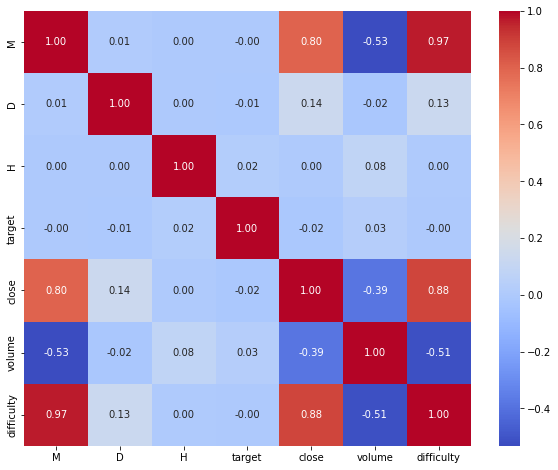

In [14]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(t2.corr(), annot=True, cmap='coolwarm', fmt='.2f') 

plt.show()


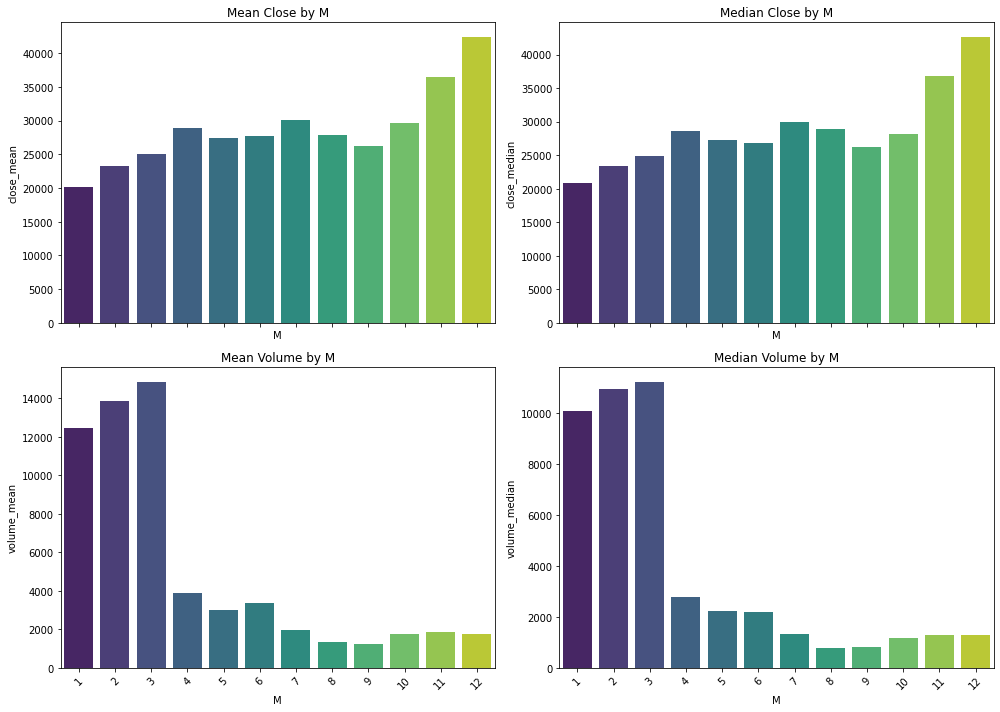

In [19]:
summary = t2.groupby('M').agg({
    'close': ['mean', 'median'],
    'volume': ['mean', 'median']
}).reset_index()

summary.columns = ['M', 'close_mean', 'close_median', 'volume_mean', 'volume_median']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Set plot titles and labels
axes[0, 0].set_title('Mean Close by M')
axes[0, 1].set_title('Median Close by M')
axes[1, 0].set_title('Mean Volume by M')
axes[1, 1].set_title('Median Volume by M')

# Plot mean and median of 'close' and 'volume'
sns.barplot(x='M', y='close_mean', data=summary, ax=axes[0, 0], palette='viridis')
sns.barplot(x='M', y='close_median', data=summary, ax=axes[0, 1], palette='viridis')
sns.barplot(x='M', y='volume_mean', data=summary, ax=axes[1, 0], palette='viridis')
sns.barplot(x='M', y='volume_median', data=summary, ax=axes[1, 1], palette='viridis')

# Rotate x labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Month에 따라 close와 difficulty는 올라간다. 즉, 시간이 갈수록 close와 difficulty는 오르는 경향이 있다.

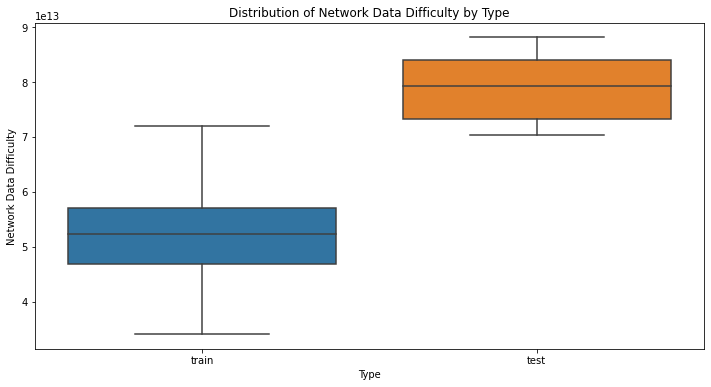

In [18]:
data = df[['network-data_difficulty_difficulty', '_type']]


plt.figure(figsize=(12, 6))  # 그림 크기 조정
sns.boxplot(data=data, x='_type', y='network-data_difficulty_difficulty')  # 박스 플롯 생성

plt.title('Distribution of Network Data Difficulty by Type')
plt.xlabel('Type')
plt.ylabel('Network Data Difficulty')

plt.show()


- difficulty는 test와 train의 범위가 거의 겹치지 않으므로 difficulty는 tree 모델에서 큰 역할을 하지 못할 것으로 보임. 따라서, Month 변수를 대신 사용하겠다.

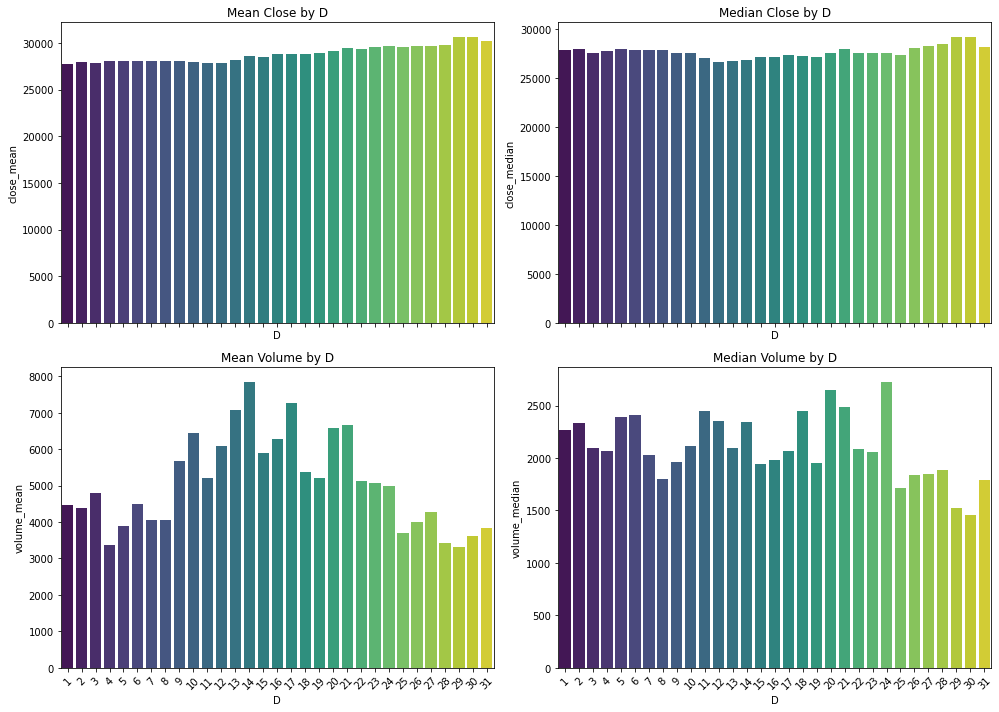

In [20]:
summary = t2.groupby('D').agg({
    'close': ['mean', 'median'],
    'volume': ['mean', 'median']
}).reset_index()

summary.columns = ['D', 'close_mean', 'close_median', 'volume_mean', 'volume_median']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Set plot titles and labels
axes[0, 0].set_title('Mean Close by D')
axes[0, 1].set_title('Median Close by D')
axes[1, 0].set_title('Mean Volume by D')
axes[1, 1].set_title('Median Volume by D')

# Plot mean and median of 'close' and 'volume'
sns.barplot(x='D', y='close_mean', data=summary, ax=axes[0, 0], palette='viridis')
sns.barplot(x='D', y='close_median', data=summary, ax=axes[0, 1], palette='viridis')
sns.barplot(x='D', y='volume_mean', data=summary, ax=axes[1, 0], palette='viridis')
sns.barplot(x='D', y='volume_median', data=summary, ax=axes[1, 1], palette='viridis')

# Rotate x labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- 비교적 월의 중순에 거래량이 많은 편이다.

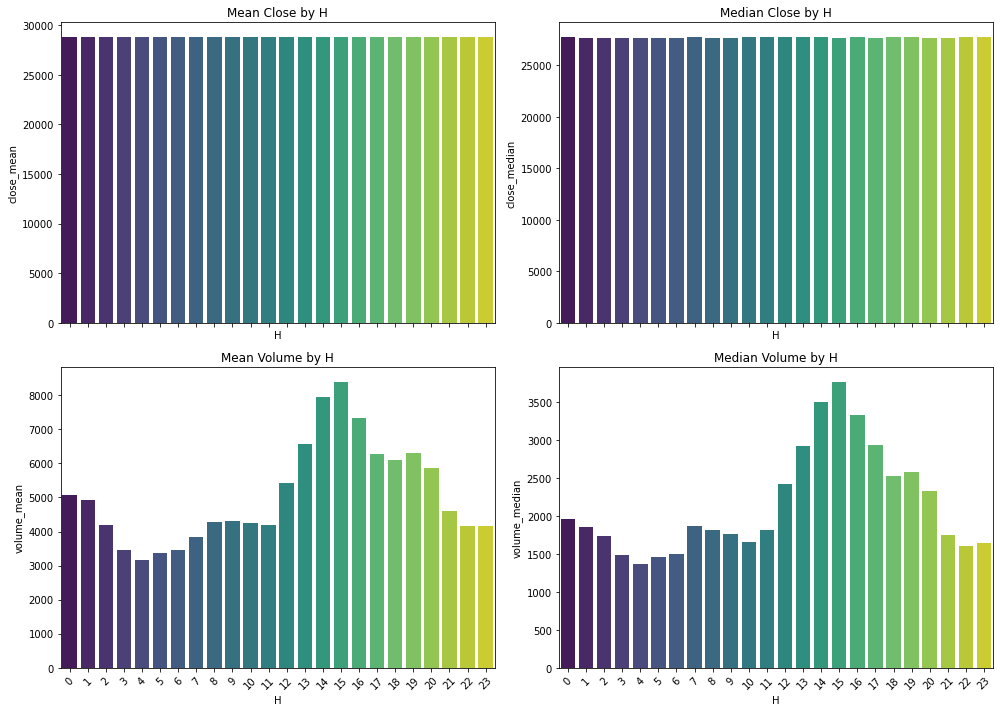

In [21]:
summary = t2.groupby('H').agg({
    'close': ['mean', 'median'],
    'volume': ['mean', 'median']
}).reset_index()

summary.columns = ['H', 'close_mean', 'close_median', 'volume_mean', 'volume_median']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Set plot titles and labels
axes[0, 0].set_title('Mean Close by H')
axes[0, 1].set_title('Median Close by H')
axes[1, 0].set_title('Mean Volume by H')
axes[1, 1].set_title('Median Volume by H')

# Plot mean and median of 'close' and 'volume'
sns.barplot(x='H', y='close_mean', data=summary, ax=axes[0, 0], palette='viridis')
sns.barplot(x='H', y='close_median', data=summary, ax=axes[0, 1], palette='viridis')
sns.barplot(x='H', y='volume_mean', data=summary, ax=axes[1, 0], palette='viridis')
sns.barplot(x='H', y='volume_median', data=summary, ax=axes[1, 1], palette='viridis')

# Rotate x labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- 거래가 가장 활발한 시간은 13시~20시 이다.

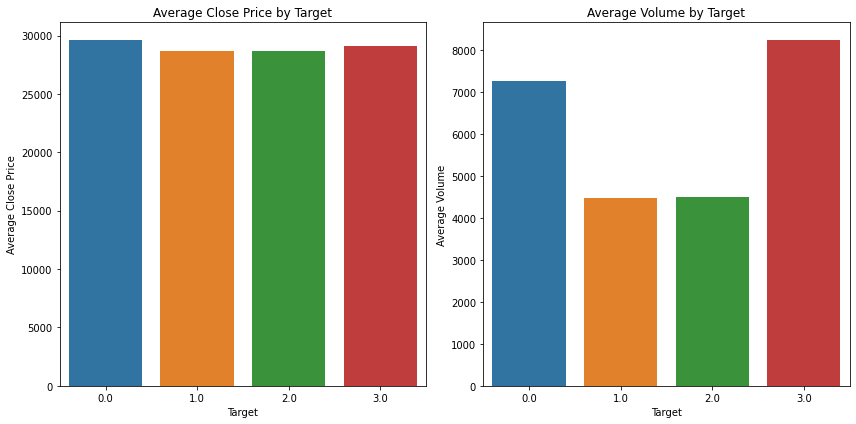

In [22]:
close_mean = t2.groupby('target')['close'].mean().reset_index()
volume_mean = t2.groupby('target')['volume'].mean().reset_index()

plt.figure(figsize=(12, 6))

# close 평균
plt.subplot(1, 2, 1)
sns.barplot(x='target', y='close', data=close_mean)
plt.title('Average Close Price by Target')
plt.xlabel('Target')
plt.ylabel('Average Close Price')

# volume 평균
plt.subplot(1, 2, 2)
sns.barplot(x='target', y='volume', data=volume_mean)
plt.title('Average Volume by Target')
plt.xlabel('Target')
plt.ylabel('Average Volume')

plt.tight_layout()
plt.show()


- 상승/감소의 폭이 클수록 거래량이 높음을 알 수 있다.
- 따라서 거래량이 비교적 많은 13~20시 를 나타내는 변수를 추가하겠다.

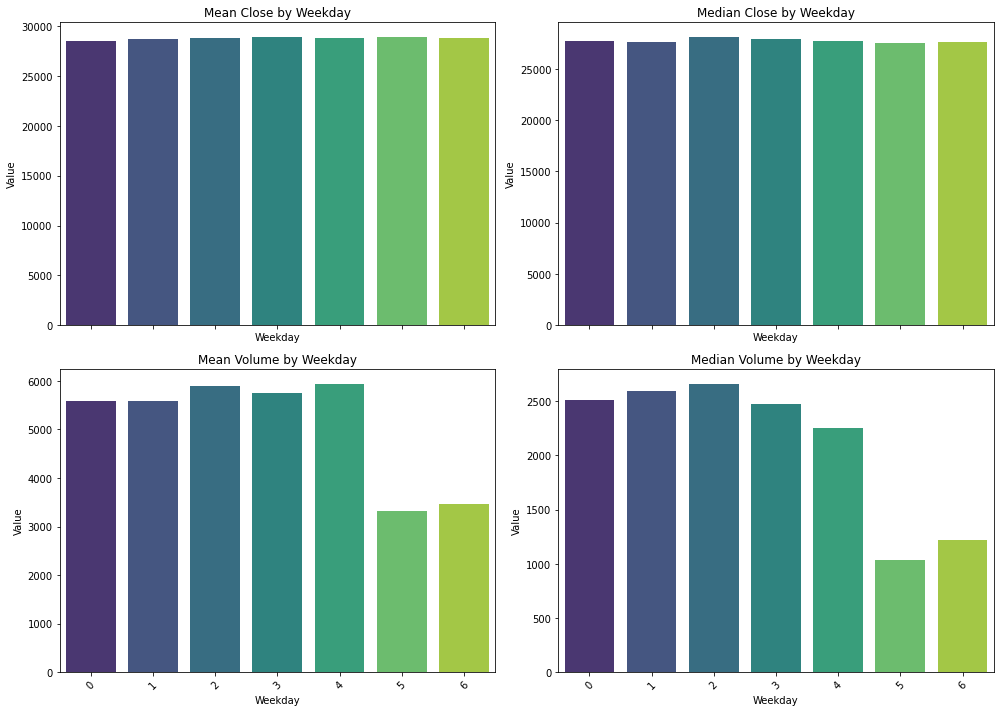

In [23]:
summary = t2.groupby('Weekday').agg({
    'close': ['mean', 'median'],
    'volume': ['mean', 'median']
}).reset_index()

summary.columns = ['Weekday', 'close_mean', 'close_median', 'volume_mean', 'volume_median']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Set plot titles and labels
axes[0, 0].set_title('Mean Close by Weekday')
axes[0, 1].set_title('Median Close by Weekday')
axes[1, 0].set_title('Mean Volume by Weekday')
axes[1, 1].set_title('Median Volume by Weekday')

# Plot mean and median of 'close' and 'volume'
sns.barplot(x='Weekday', y='close_mean', data=summary, ax=axes[0, 0], palette='viridis')
sns.barplot(x='Weekday', y='close_median', data=summary, ax=axes[0, 1], palette='viridis')
sns.barplot(x='Weekday', y='volume_mean', data=summary, ax=axes[1, 0], palette='viridis')
sns.barplot(x='Weekday', y='volume_median', data=summary, ax=axes[1, 1], palette='viridis')

# Rotate x labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

# y축 레이블 추가
for ax in axes.flat:
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()


- 주말의 거래량이 적으므로 주말을 나타내는 변수를 추가하겠다.